In [3]:
import numpy as np
import pandas as pd
import scipy.stats as st
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import bootstrap
import pandahouse as ph
from scipy.sparse import csr_matrix


In [8]:
connection = {
    'host': 'https://clickhouse.lab.karpov.courses',
    'password': 'dpo_python_2020',
    'user': 'student',
    'database': 'simulator'
}

In [10]:
#условие размера графиков
sns.set(rc={'figure.figsize':(14,6)}, style="whitegrid")

In [6]:
q = """
SELECT exp_group, 
    user_id,
    sum(action = 'like') as likes,
    sum(action = 'view') as views,
    likes/views as ctr
FROM simulator_20231113.feed_actions 
WHERE toDate(time) between '2023-10-25' and '2023-10-31'
    and exp_group in (2,1)
GROUP BY exp_group, user_id
"""

df = ph.read_clickhouse(q, connection=connection)

#T-тест

st.ttest_ind(df[df.exp_group == 2].ctr,
                df[df.exp_group == 1].ctr,
                equal_var=False)

Ttest_indResult(statistic=-0.4051491913112757, pvalue=0.685373331140751)

In [ ]:
#В результате T-теста pvalue>0,05 , но поспешных вывоводов о том что различий нет. я бы не делелал

In [6]:
df

,exp_group,user_id,likes,views,ctr
0,1,109963,3,15,0.200000
1,1,26117,32,141,0.226950
2,1,138232,18,73,0.246575
3,1,18392,7,32,0.218750
4,1,26295,39,141,0.276596
...,...,...,...,...,...
19892,2,17146,0,10,0.000000
19893,1,30872,11,59,0.186441
19894,2,25383,42,127,0.330709
19895,2,139020,17,41,0.414634


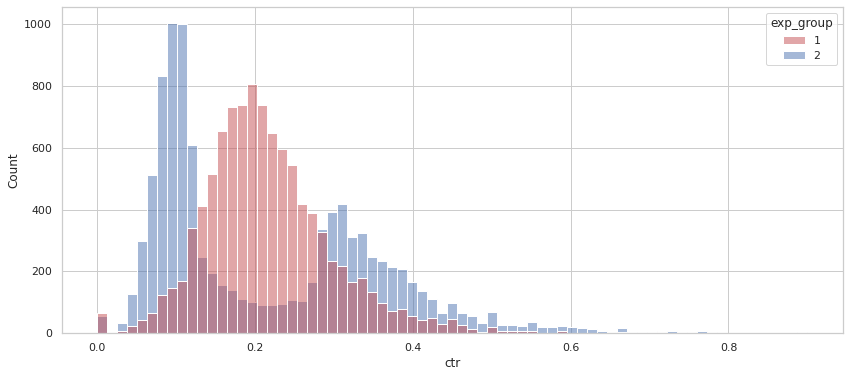

In [11]:
# на графике мы видим, что распределение контрольной группы нормальное , а тестовой группы нет!
# поэтому расчитывать на т-тест пока не стоит
groups = sns.histplot(data = df, 
              x='ctr', 
              hue='exp_group', 
              palette = ['r', 'b'],
              alpha=0.5,
              kde=False)


In [13]:
# тест Манна-Уитни говорит нам о том, что различия есть и очень большое
st.mannwhitneyu(df[df.exp_group == 2].ctr, 
                   df[df.exp_group == 1].ctr,
                   alternative = 'two-sided')

MannwhitneyuResult(statistic=43777627.0, pvalue=4.632205841806026e-45)

In [ ]:
# Начнем искать Сглаженный CTR и делать т-тест

In [12]:

def get_smothed_ctr(user_likes, user_views, global_ctr, alpha):
    smothed_ctr = (user_likes + alpha * global_ctr) / (user_views + alpha)
    return smothed_ctr

/tmp/ipykernel_52/158687240.py:5: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(group1.ctr,


<Axes: xlabel='ctr'>

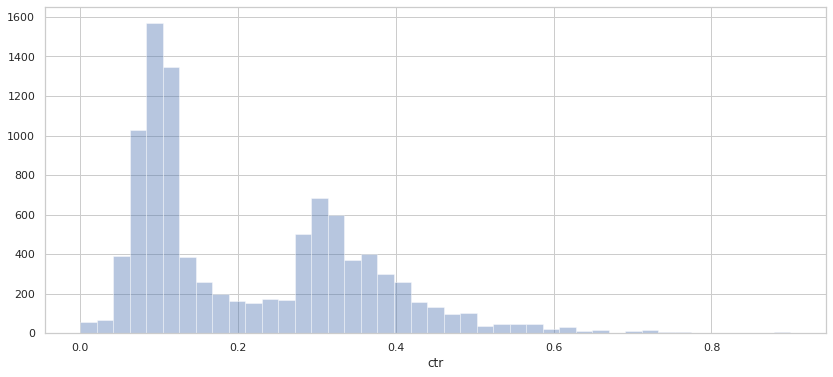

In [13]:
global_ctr_1 = df[df.exp_group == 2].likes.sum()/df[df.exp_group == 2].views.sum()
global_ctr_2 = df[df.exp_group == 1].likes.sum()/df[df.exp_group == 1].views.sum()

group1 = df[df.exp_group == 2].copy()
sns.distplot(group1.ctr, 
             kde = False)



/tmp/ipykernel_52/1611455772.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(group2.ctr,


<Axes: xlabel='ctr'>

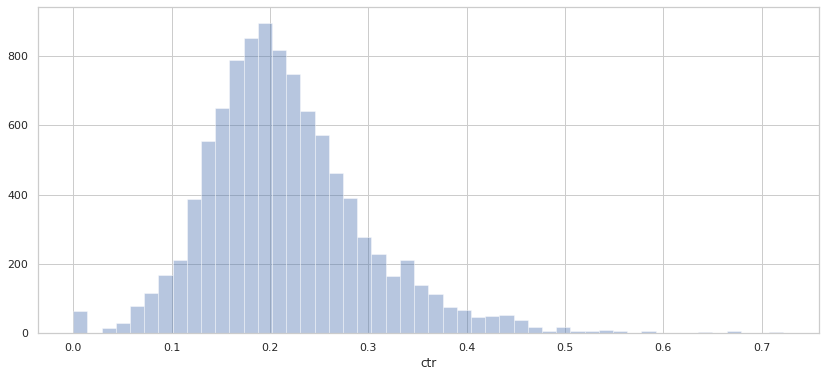

In [14]:
group2 = df[df.exp_group == 1].copy()
sns.distplot(group2.ctr, 
             kde = False)

/tmp/ipykernel_52/3166361466.py:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(group1.smothed_ctr,


<Axes: xlabel='smothed_ctr'>

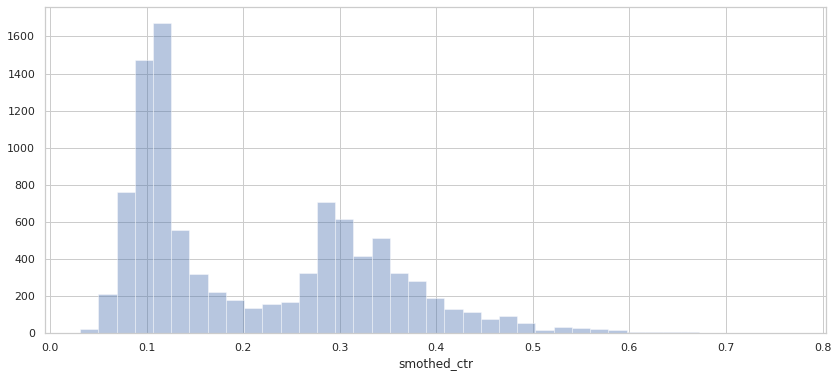

In [15]:
group1['smothed_ctr'] = df.apply(
    lambda x: get_smothed_ctr(x['likes'], x['views'], global_ctr_1, 5), axis=1)

sns.distplot(group1.smothed_ctr, 
             kde = False)

/tmp/ipykernel_52/3144439404.py:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(group2.smothed_ctr,


<Axes: xlabel='smothed_ctr'>

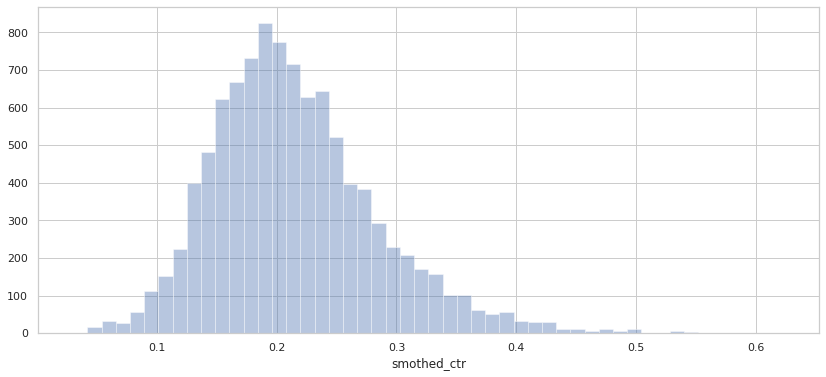

In [16]:
group2['smothed_ctr'] = df.apply(
    lambda x: get_smothed_ctr(x['likes'], x['views'], global_ctr_2, 5), axis=1)

sns.distplot(group2.smothed_ctr, 
             kde = False)

In [22]:
group1

,exp_group,user_id,likes,views,ctr,smothed_ctr
5,2,131473,9,108,0.083333,0.088507
6,2,23985,7,87,0.080460,0.086970
7,2,24523,11,101,0.108911,0.113219
8,2,32420,13,44,0.295455,0.285740
9,2,24239,40,90,0.444444,0.431592
...,...,...,...,...,...,...
19889,2,25071,7,18,0.388889,0.347881
19892,2,17146,0,10,0.000000,0.066750
19894,2,25383,42,127,0.330709,0.325767
19895,2,139020,17,41,0.414634,0.391332


In [18]:
group2

,exp_group,user_id,likes,views,ctr,smothed_ctr
0,1,109963,3,15,0.200000,0.202401
1,1,26117,32,141,0.226950,0.226356
2,1,138232,18,73,0.246575,0.244205
3,1,18392,7,32,0.218750,0.217514
4,1,26295,39,141,0.276596,0.274302
...,...,...,...,...,...,...
19886,1,31540,7,39,0.179487,0.182910
19887,1,23359,12,32,0.375000,0.352649
19890,1,110956,3,16,0.187500,0.192763
19891,1,132567,52,326,0.159509,0.160266


In [17]:
groups_all = pd.concat([group1, group2], axis=0)

In [18]:
groups_all

,exp_group,user_id,likes,views,ctr,smothed_ctr
5,2,131473,9,108,0.083333,0.088507
6,2,23985,7,87,0.080460,0.086970
7,2,24523,11,101,0.108911,0.113219
8,2,32420,13,44,0.295455,0.285740
9,2,24239,40,90,0.444444,0.431592
...,...,...,...,...,...,...
19886,1,31540,7,39,0.179487,0.182910
19887,1,23359,12,32,0.375000,0.352649
19890,1,110956,3,16,0.187500,0.192763
19891,1,132567,52,326,0.159509,0.160266


In [22]:
# т-тест сглаженного CTR  показывает что pvalue=0.0516 , можно предположить что значимое различие есть 
st.ttest_ind(groups_all[groups_all.exp_group == 2].smothed_ctr,
                groups_all[groups_all.exp_group == 1].smothed_ctr,
                equal_var=False)

Ttest_indResult(statistic=-1.9460491517027683, pvalue=0.05166679015318526)

In [23]:
# тест Манна-Уитни по-прежнему говорит нам о том, что различия есть и очень большое и значимое
st.mannwhitneyu(groups_all[groups_all.exp_group == 2].smothed_ctr,
                groups_all[groups_all.exp_group == 1].smothed_ctr,
                alternative = 'two-sided')

MannwhitneyuResult(statistic=43439187.0, pvalue=2.396534039374286e-50)

In [23]:
exp_group_2 = group1[["ctr"]].copy()

In [24]:
exp_group_2

,ctr
5,0.083333
6,0.080460
7,0.108911
8,0.295455
9,0.444444
...,...
19889,0.164557
19892,0.000000
19894,0.330709
19895,0.414634


In [25]:
exp_group_1 = group2[["ctr"]].copy()

In [ ]:
#метод bootsrap показывает нам , что доверительные интервалы обеих групп пересекаются , значит стат различий нет

In [72]:
bootstrap((exp_group_2.ctr, ), np.mean) # Используем статистический метод bootsrap и находим доверительный интервал статистических
#показателей тестовой группы

BootstrapResult(confidence_interval=ConfidenceInterval(low=0.2133107228371321, high=0.21889248690612206), bootstrap_distribution=array([0.21602361, 0.21700241, 0.2182326 , ..., 0.21571761, 0.2187697 ,
       0.21349676]), standard_error=0.0014416702801972033)

In [73]:
bootstrap((exp_group_1.ctr, ), np.mean) # Используем статистический метод bootsrap и находим доверительный интервал статистических
#показателей контрольной группы

BootstrapResult(confidence_interval=ConfidenceInterval(low=0.21521464082777556, high=0.21837824110719115), bootstrap_distribution=array([0.21650977, 0.21721167, 0.21562775, ..., 0.21688709, 0.21525385,
       0.21751233]), standard_error=0.0008180436323482408)

In [19]:
#Пуассоновский бутстреп говорит нам о том что статистические различия есть
def bootstrap(likes1, views1, likes2, views2, n_bootstrap=2000):

    poisson_bootstraps1 = st.poisson(1).rvs(
        (n_bootstrap, len(likes1))).astype(np.int64)

    poisson_bootstraps2 = st.poisson(1).rvs(
            (n_bootstrap, len(likes2))).astype(np.int64)
    
    globalCTR1 = (poisson_bootstraps1*likes1).sum(axis=1)/(poisson_bootstraps1*views1).sum(axis=1)
    
    globalCTR2 = (poisson_bootstraps2*likes2).sum(axis=1)/(poisson_bootstraps2*views2).sum(axis=1)

    return globalCTR1, globalCTR2





In [20]:
likes1 = df[df.exp_group == 2].likes.to_numpy()
views1 = df[df.exp_group == 2].views.to_numpy()
likes2 = df[df.exp_group == 1].likes.to_numpy()
views2 = df[df.exp_group == 1].views.to_numpy()

ctr1, ctr2 = bootstrap(likes1, views1, likes2, views2)

<Axes: ylabel='Count'>

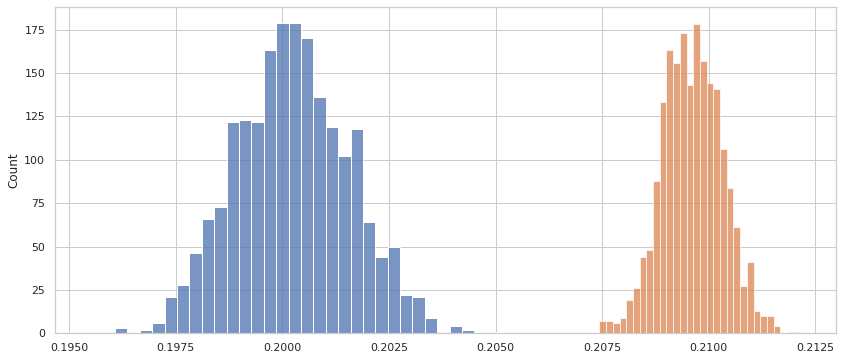

In [21]:
sns.histplot(ctr1)
sns.histplot(ctr2)

<Axes: ylabel='Count'>

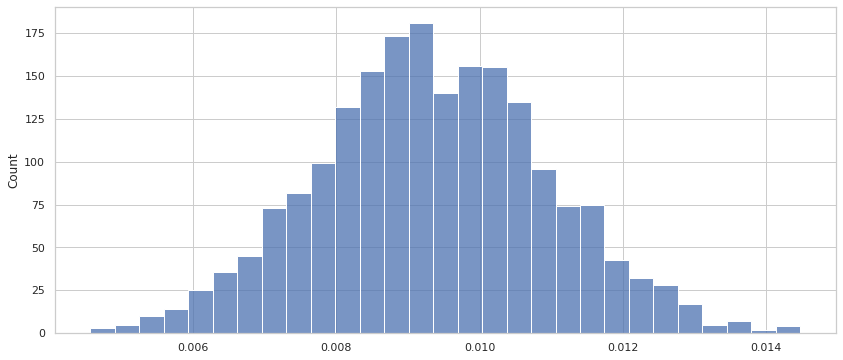

In [46]:
#Разница между глобальными CTR

sns.histplot(ctr2 - ctr1)


In [49]:
#Бакетное преобразование 
q_2 = """

SELECT exp_group, bucket,
    sum(likes)/sum(views) as bucket_ctr,
    quantileExact(0.9)(ctr) as ctr9
FROM (SELECT exp_group, 
        xxHash64(user_id)%50 as bucket,
        user_id,
        sum(action = 'like') as likes,
        sum(action = 'view') as views,
        likes/views as ctr
    FROM simulator_20231113.feed_actions
    WHERE toDate(time) between '2023-10-25' and '2023-10-31'
        and exp_group in (2,1)
    GROUP BY exp_group, bucket, user_id)
GROUP BY exp_group, bucket
"""

df_2 = ph.read_clickhouse(q_2, connection=connection)

In [50]:
df_2

,exp_group,bucket,bucket_ctr,ctr9
0,1,0,0.200592,0.305556
1,2,0,0.196510,0.385321
2,1,1,0.208799,0.311111
3,2,1,0.210375,0.485714
4,1,2,0.204632,0.314286
...,...,...,...,...
95,2,47,0.196808,0.428571
96,1,48,0.216369,0.320000
97,2,48,0.194780,0.400000
98,1,49,0.206288,0.333333


In [51]:
#тест Манна-Уитни при Бакетном преобразовании видит отличие
st.mannwhitneyu(df_2[df_2.exp_group == 2].bucket_ctr, 
                   df_2[df_2.exp_group == 1].bucket_ctr, 
                   alternative = 'two-sided')

MannwhitneyuResult(statistic=503.0, pvalue=2.6576427804010095e-07)

In [52]:
#и t-тест тоже
st.ttest_ind(df_2[df_2.exp_group == 2].bucket_ctr, 
                   df_2[df_2.exp_group == 1].bucket_ctr, 
                   equal_var = False)

Ttest_indResult(statistic=-5.614819358149381, pvalue=4.592644937473873e-07)

<Axes: xlabel='bucket_ctr', ylabel='Count'>

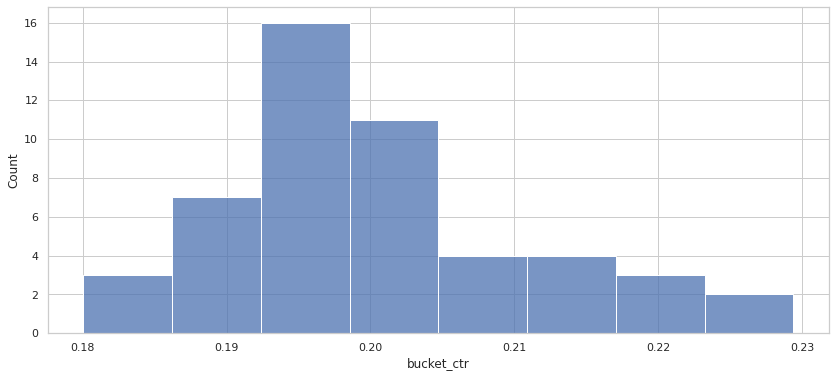

In [53]:
sns.histplot(df_2[df_2.exp_group == 2].bucket_ctr)

<Axes: xlabel='bucket_ctr', ylabel='Count'>

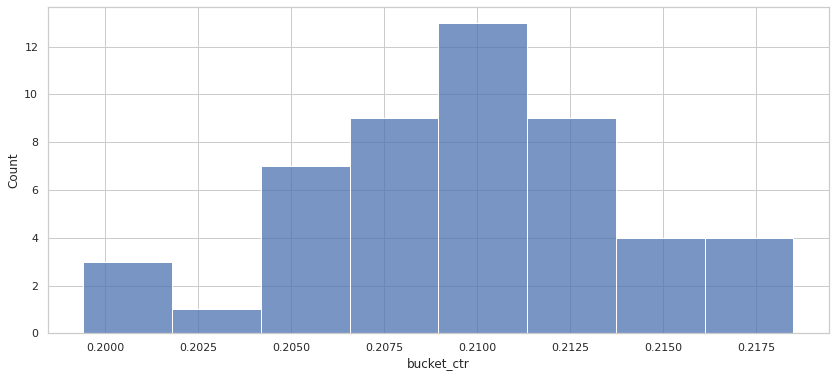

In [54]:
sns.histplot(df_2[df_2.exp_group == 1].bucket_ctr)

In [1]:
#Вывод:
#1) В результате T-теста pvalue>0,05  для обычного CTR и значимых различий нет, это может быть из-за того , что в распределение в тестовой группе ненормальное 
#2) В результате теста Манна-Уитни pvalue<0,05  для обычного CTR и значимые различия есть 
#3) Т-тест сглаженного CTR  показывает что pvalue=0.0516 , можно предположить что значимое различие есть, может быть потому что сработало сглаживание как если бы мы прологорифмировали и тем самым, уменьшили стандартное отклонение 
#4) Тест Манна-Уитни сглаженного CTR по-прежнему говорит нам о том, что различия есть и очень большое и значимое
#5) Метод bootsrap показывает нам , что доверительные интервалы обеих групп пересекаются , значит стат различий нет
#6) Пуассоновский бутстреп говорит нам о том что статистические различия есть, может потому что в этом случае распределение значение нормальное а при обычном методе bootsrap нет !
#7) Тест Манна-Уитни при Бакетном преобразовании видит отличие
#8) И t-тест тоже  при Бакетном преобразовании видит отличие
#Результаты тестов неоднозначные, в большестве случаев при тестировании показывает , что стат значимые различия есть и скорре всего запускать 
#новый алгоритм стоит